In [1]:
using PyPlot
include("acoustic_solver.jl")
include("barycenter.jl")

barycenter_unbalanced_1d_signal (generic function with 1 method)

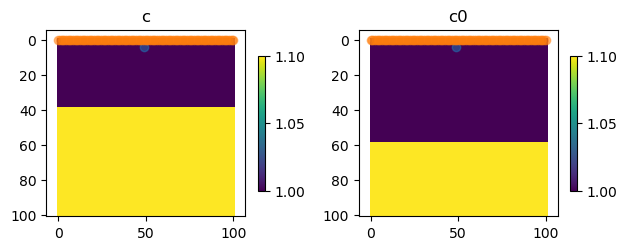

In [4]:
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(1,2)
for i = 1:1
    source_position[i,:] = [5 50]
end
# source = repeat(source, 1, 11)

receiver_position = zeros(101,2)
for i = 1:101
    receiver_position[i,:] = [1, (i-1)*1+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
c[40:end,:] .= 1.1

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
c0[60:end,:] .= 1.1

cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 100

figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [5]:
@time data, u = acoustic_eq_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time data0, u0 = acoustic_eq_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time datac, uc = acoustic_eq_solver(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

  5.988813 seconds (201.25 k allocations: 10.397 GiB, 20.14% gc time)
  5.934444 seconds (201.25 k allocations: 10.397 GiB, 19.54% gc time)
  5.858679 seconds (201.25 k allocations: 10.397 GiB, 20.06% gc time)


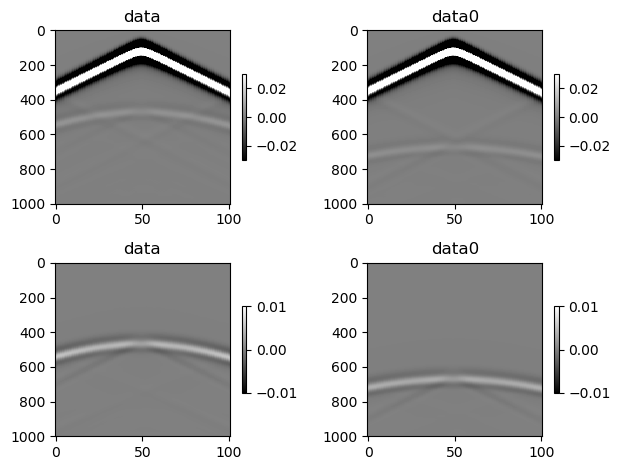

In [6]:
figure
subplot(221)
imshow(data, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.5); clim([-0.03,0.03])

subplot(222)
imshow(data0, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.5); clim([-0.03,0.03])

subplot(223)
imshow(data-datac, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.5); clim([-0.01,0.01])

subplot(224)
imshow(data0-datac, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.5); clim([-0.01,0.01])

tight_layout()

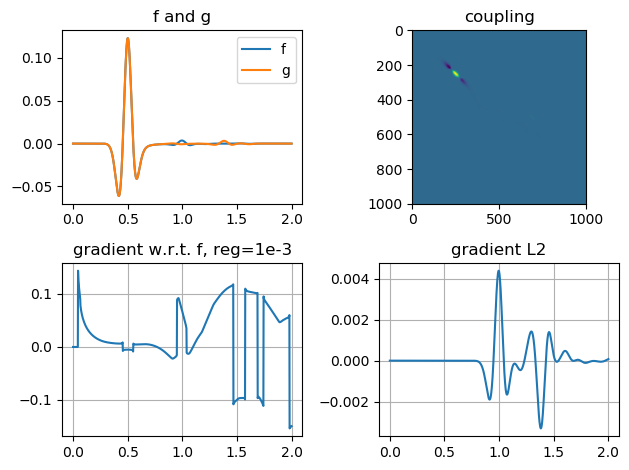

In [8]:
ind1 = 21
f = data[:,ind1]-datac[:,ind1]
g = data0[:,ind1]-datac[:,ind1]
f = data[:,ind1]
g = data0[:,ind1]
M = cost_matrix_1d(t, t; p=2)

reg = 1e-3
reg_m = 1e2

TT,gg,dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
figure;
subplot(221); plot(t,f,t,g); title("f and g"); legend(["f", "g"])
subplot(222); imshow(TT); title("coupling")
subplot(223); plot(t,gg); title("gradient w.r.t. f, reg=1e-3"); grid("on")
subplot(224); plot(t,f-g); title("gradient L2"); grid("on")
tight_layout()

In [9]:
adj_source = zeros(Nt,101)
for ind = 1:101
#     f = data[:,ind]-datac[:,ind]
#     g = data0[:,ind]-datac[:,ind]
    f = data[:,ind]
    g = data0[:,ind]
    TT,adj_source[:,ind],dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
end

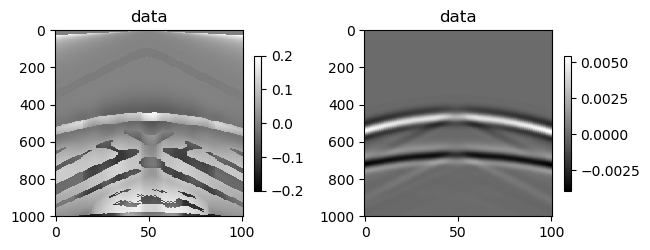

In [10]:
subplot(121)
imshow(adj_source, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.3); clim([-0.2,0.2])
subplot(122)
imshow(data-data0, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.3)
tight_layout()

In [11]:
@time pw2 = backward_solver(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time pl2 = backward_solver(c, rho, Nx, Ny, Nt, h, dt, data-data0, source_position, receiver_position; pml_len=10, pml_coef=100);

  7.605949 seconds (2.77 M allocations: 10.584 GiB, 16.96% gc time)
  6.010000 seconds (201.26 k allocations: 10.476 GiB, 20.46% gc time)


In [12]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_w = uu[:,:,end:-1:1,:].*pw2
grad_w = sum(grad_w, dims=[3,4])
grad_w = grad_w[:,:,1,1]

uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_l2 = uu[:,:,end:-1:1,:].*pl2
grad_l2 = sum(grad_l2, dims=[3,4])
grad_l2 = grad_l2[:,:,1,1];

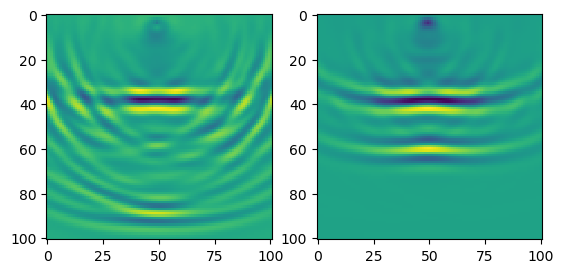

PyObject <matplotlib.image.AxesImage object at 0x14675b410>

In [13]:
subplot(121)
imshow(grad_w)
subplot(122)
imshow(grad_l2)